# download file

In [ ]:
# !gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "./crypko_data.zip"

In [ ]:
# !unzip -q "./crypko_data.zip" -d "./"

In [ ]:
# !cd faces && ls -U | head -4

In [ ]:
!python -V

# import

In [1]:
import numpy as np
import os
import random
import cv2
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd

from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# data

## check file

In [ ]:
dir_name = '/workdir/home/feynman52/NTU-ML2020/hw11-gan/datasets/faces'
file_name = '33077.jpg'
file_path = os.path.join(dir_name, file_name)
file_path

In [ ]:
img = cv2.imread(file_path)
img.shape, type(img)

In [ ]:
plt.imshow(img, interpolation='nearest')

In [ ]:
# glob('./faces/*')

## dataset

In [2]:
class TestDataset(Dataset):
    def __init__(self):
        self.data = list(range(10))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        
        
testDataset = TestDataset()
len(testDataset)



10

In [ ]:
[0, 1, 2, 3, 4, 5]

[5, 1, 2, 0, 4, 5]

In [ ]:
batch_size = 4
t_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

for i, xy in enumerate(t_loader):
    print(xy)
    

In [ ]:
batch_size = 4
t_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

for epoch in range(3):
    xy = next(iter(t_loader))
    print(xy)
    

In [3]:
class FaceDataset(Dataset):
    def __init__(self, img_dir='/workdir/home/feynman52/NTU-ML2020/hw11-gan/datasets/faces', ):
        self.img_dir = img_dir
        self.setup()

    def setup(self):
        self.setup_data()
        self.setup_transform()

    def setup_data(self):
        self.data = glob(os.path.join(self.img_dir, '*'))[:]

    def setup_transform(self):
        transform_steps = [transforms.ToPILImage(),
                            transforms.Resize((64, 64)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ]
        self.transform_fn = transforms.Compose(transform_steps)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform_fn(img)
        return img

faceDataset = FaceDataset()
len(faceDataset)


71314

## dataloader

In [ ]:
batch_size = 50
train_loader = DataLoader(faceDataset, batch_size=batch_size, shuffle=True)
x = next(iter(train_loader))
x.shape

# model

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class NetG(nn.Module):
    def __init__(self, in_dim, dim=64):
        super().__init__()

        self.dim = dim
        self.in_dim = in_dim
        self.setup_layer()  
        self.apply(weights_init)
    
    def setup_layer(self):
        self.l1 = nn.Sequential(nn.Linear(self.in_dim, self.dim * 8 * 4 * 4, bias=False),
                                nn.BatchNorm1d(self.dim * 8 * 4 * 4),
                                nn.ReLU())
        
        self.l2_5 = nn.Sequential(self.dconv_bn_relu(self.dim * 8, self.dim * 4),
                                    self.dconv_bn_relu(self.dim * 4, self.dim * 2),
                                    self.dconv_bn_relu(self.dim * 2, self.dim),
                                    nn.ConvTranspose2d(self.dim, 3, 5, 2, padding=2, output_padding=1),
                                    nn.Tanh())

    def dconv_bn_relu(self, in_dim, out_dim):
        convTranspose2d = nn.ConvTranspose2d(in_dim, out_dim, 
                                            5, 2,
                                            padding=2, 
                                            output_padding=1, 
                                            bias=False)
        net = nn.Sequential(convTranspose2d,
                            nn.BatchNorm2d(out_dim),
                            nn.ReLU())
        return net

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


In [5]:
class NetD(nn.Module):
    def __init__(self, in_dim, dim=64):
        super().__init__()

        self.dim = dim
        self.in_dim = in_dim
        self.setup_layer()
        self.apply(weights_init)  
    
    def setup_layer(self):
        self.ls = nn.Sequential(nn.Conv2d(self.in_dim, self.dim, 5, 2, 2), 
                                nn.LeakyReLU(0.2),
                                self.conv_bn_lrelu(self.dim, self.dim * 2),
                                self.conv_bn_lrelu(self.dim * 2, self.dim * 4),
                                self.conv_bn_lrelu(self.dim * 4, self.dim * 8),
                                nn.Conv2d(self.dim * 8, 1, 4),
                                nn.Sigmoid())
        
    def conv_bn_lrelu(self, in_dim, out_dim):
        net = nn.Sequential(nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                            nn.BatchNorm2d(out_dim),
                            nn.LeakyReLU(0.2))
        return net

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y


# train and test

## train

In [6]:
from torch.autograd import Variable

In [7]:
class TrainAndTest:
    def __init__(self, option):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.option = option
        self.setup()

    def setup(self):
        self.setup_data()
        self.setup_model()
        self.setup_optimizer()
        self.setup_criterion()
        self.setup_history()

    def setup_data(self):
        faceDataset = FaceDataset()
        self.train_loader = DataLoader(faceDataset, batch_size=self.option.batch_size, shuffle=True)

    def setup_model(self):
        self.netG = NetG(in_dim=self.option.z_dim).to(self.device) #!
        self.netD = NetD(3).to(self.device) #!

    def setup_optimizer(self):
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=self.option.lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=self.option.lr, betas=(0.5, 0.999))

    def setup_criterion(self):
        self.criterion = nn.BCELoss()

    def setup_history(self,):
        self.df_history = pd.DataFrame()
        
    def train_one_epoch(self):
        loss_G = 0.0
        loss_D = 0.0
        
        for i, x_y in enumerate(self.train_loader):
            batch_loss_G, batch_loss_D = train_one_batch(self, x_y)
            loss_G += batch_loss_G
            loss_D += batch_loss_D

        loss_G /= len(self.train_loader)
        loss_D /= len(self.train_loader)
        return loss_G, loss_D

    def train_one_batch(self, x_y):
        self.netG.train()
        self.netD.train()

        """ Train D """
        # img
        x = x_y.to(self.device)
        batch_size = len(x)
        z = Variable(torch.randn(batch_size, self.option.z_dim)).to(self.device)

        r_imgs = Variable(x)
        f_imgs = self.netG(z)

        # label
        r_label = torch.ones((batch_size)).to(self.device)
        f_label = torch.zeros((batch_size)).to(self.device)

        # D
        r_logit = self.netD(r_imgs)
        f_logit = self.netD(f_imgs)

        # compute loss
        r_loss = self.criterion(r_logit, r_label)
        f_loss = self.criterion(f_logit, f_label)
        batch_loss_D = (r_loss + f_loss) / 2

        self.optimizer_D.zero_grad()
        batch_loss_D.backward()
        self.optimizer_D.step()

        batch_loss_D = batch_loss_D.item()


        """ train G """
        # leaf
        z = Variable(torch.randn(batch_size, self.option.z_dim)).to(self.device)
        f_imgs = self.netG(z)

        # dis
        f_logit = self.netD(f_imgs)

        # compute loss
        batch_loss_G = self.criterion(f_logit, r_label)

        # update model
        self.netG.zero_grad()
        batch_loss_G.backward()
        self.optimizer_G.step()

        batch_loss_G = batch_loss_G.item()
        
        return batch_loss_G, batch_loss_D
    
    def sample_imgs(self, epoch=None):
        file_name = 'epoch-%s---model-netG.pth'%(epoch)
        path = os.path.join('.', 'weights', file_name)
        
        model = self.netG
        model.load_state_dict(torch.load(path))
        model.eval()
        
        batch_size = 20
        z_sample = Variable(torch.randn(batch_size, self.option.z_dim)).to(self.device)
        imgs_sample = model(z_sample)
        
        imgs = imgs_sample.detach().cpu().numpy() # detach gradient, gpu to cpu, tensor to numpy
        imgs = (imgs + 1) / 2.0 #?
        '''
        -1 ~ 1
        0 ~ 2
        0 ~ 1
        '''
        return imgs
        
    
    def save_model(self, epoch, loss_G, loss_D):
        file_name = 'epoch-%s---model-netG.pth'%(epoch)
        path = os.path.join('.', 'weights', file_name)
        torch.save(self.netG.state_dict(), path)
        
        file_name = 'epoch-%s---model-netD.pth'%(epoch)
        path = os.path.join('.', 'weights', file_name)
        torch.save(self.netD.state_dict(), path)
        
        # history
        row = pd.DataFrame()
        row['epoch'] = [epoch]
        row['loss_G'] = [loss_G]
        row['loss_D'] = [loss_D]
        self.df_history = self.df_history.append(row)
        self.df_history.to_csv(os.path.join('.', 'weights', 'df_history.csv'))



In [ ]:
[0.1, 0.9] [0.1, 0.9]
[0.4, 0.6] [0.4, 0.6]

[0.5, 0.5] [0.5, 0.5]


In [8]:
class Option:
    def __init__(self):
        self.batch_size = 64
        self.z_dim = 100
        self.lr = 1e-4
        self.n_epoch = 10

option = Option()
option.lr

0.0001

In [9]:
trainAndTest = TrainAndTest(option)


In [ ]:

for epoch in range(1000+1):
    x_y = next(iter(trainAndTest.train_loader))
    loss_G, loss_D = trainAndTest.train_one_batch(x_y)
    loss_G, loss_D = round(loss_G, 3), round(loss_D, 3)
    print(epoch, loss_G, loss_D)
    
    if epoch%100==0:
        trainAndTest.save_model(epoch, loss_G, loss_D)
        

0 4.283 0.895
1 5.384 0.203
2 5.737 0.083
3 5.376 0.072
4 5.905 0.083
5 5.779 0.107
6 5.933 0.049
7 5.974 0.076
8 6.713 0.057
9 6.742 0.038
10 6.217 0.043
11 7.127 0.05
12 6.955 0.046
13 7.327 0.03
14 7.207 0.028
15 7.238 0.046
16 7.652 0.061
17 6.484 0.049
18 8.227 0.042
19 7.823 0.026
20 7.006 0.013
21 8.493 0.037
22 7.932 0.02
23 7.47 0.029
24 10.161 0.034
25 7.611 0.071
26 8.523 0.037
27 8.657 0.02
28 8.622 0.011
29 8.726 0.013
30 7.402 0.024
31 10.465 0.047
32 9.4 0.012
33 7.62 0.006
34 9.769 0.021
35 8.219 0.015
36 8.033 0.013
37 8.297 0.023
38 7.881 0.025
39 9.587 0.033
40 9.083 0.007
41 7.757 0.02
42 11.777 0.039
43 7.6 0.027
44 11.27 0.019
45 9.641 0.017
46 7.036 0.008
47 19.479 0.04
48 1.558 0.403
49 30.723 1.125
50 37.258 0.123
51 37.88 0.332
52 36.388 0.244
53 35.43 0.002
54 35.075 0.001
55 34.564 0.0
56 34.651 0.0
57 34.547 0.0
58 34.402 0.0
59 34.283 0.001
60 34.371 0.0
61 34.456 0.0
62 34.284 0.0
63 34.274 0.0
64 34.079 0.0
65 34.333 0.0
66 34.152 0.0
67 34.094 0.0
68 33

525 3.814 0.149
526 5.385 0.211
527 4.593 0.203
528 3.845 0.286
529 3.882 0.293
530 4.211 0.188
531 3.833 0.197
532 4.271 0.182
533 4.287 0.184
534 4.982 0.129
535 4.298 0.155
536 4.163 0.312
537 4.626 0.21
538 3.665 0.165
539 2.932 0.234
540 5.005 0.236
541 4.262 0.184
542 2.935 0.204
543 6.395 0.211
544 4.599 0.214
545 2.969 0.183
546 5.713 0.247
547 4.193 0.239
548 3.659 0.28
549 4.667 0.326
550 4.372 0.371
551 2.401 0.496
552 7.96 0.5
553 3.821 0.546
554 3.818 0.258
555 4.639 0.167
556 4.593 0.314
557 5.082 0.196
558 3.148 0.341
559 5.727 0.359
560 3.9 0.3
561 5.296 0.23
562 3.051 0.292
563 4.845 0.276
564 5.064 0.17
565 2.14 0.264
566 8.532 0.46
567 3.682 0.648
568 1.727 0.203
569 8.927 0.43
570 6.309 0.405
571 3.125 0.105
572 5.51 0.307
573 4.762 0.177
574 3.023 0.191
575 6.105 0.35
576 3.503 0.341
577 5.298 0.286
578 2.909 0.272
579 7.548 0.334
580 4.755 0.315
581 4.083 0.12
582 5.755 0.182
583 5.19 0.151
584 3.498 0.172
585 6.309 0.29
586 5.439 0.136
587 3.238 0.191
588 5.488 0

In [ ]:
# trainAndTest.df_history.plot(x='epoch', y=['loss_D'])
trainAndTest.df_history.plot(x='epoch', y=['loss_G', 'loss_D'])

## test

In [10]:
def plot_one_row_imgs(imgs):
    fig=plt.figure(figsize=(8, 8))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        img = imgs[i]
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img, interpolation='nearest')
        
    plt.tight_layout()
    plt.show()

In [ ]:
# imgs = trainAndTest.sample_imgs(epoch=950)
# trans_imgs = imgs.transpose([0, 2, 3, 1])
# plt.imshow(trans_imgs[10], interpolation='nearest')


##################################################
epoch 0


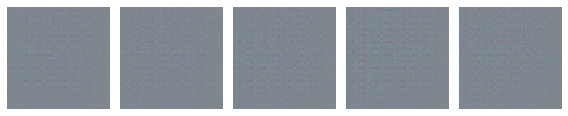

##################################################
epoch 500


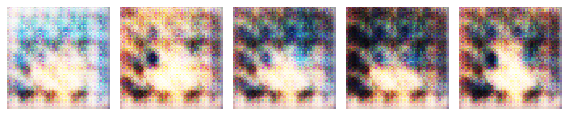

##################################################
epoch 1000


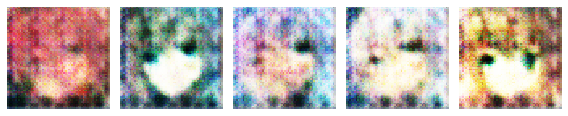

##################################################
epoch 1500


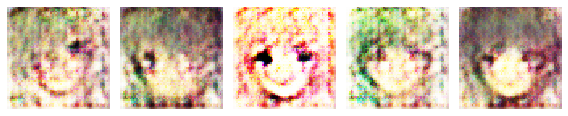

##################################################
epoch 2000


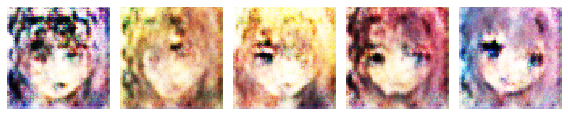

##################################################
epoch 2500


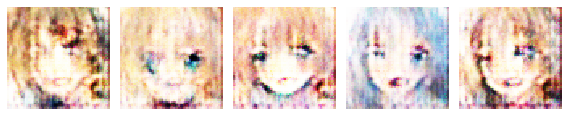

##################################################
epoch 3000


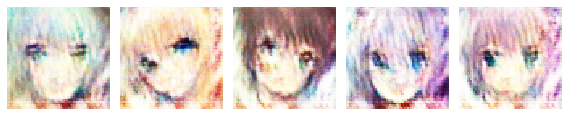

##################################################
epoch 3500


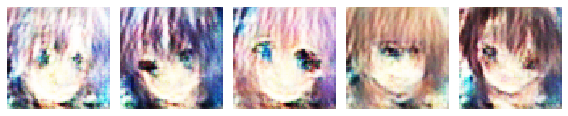

##################################################
epoch 4000


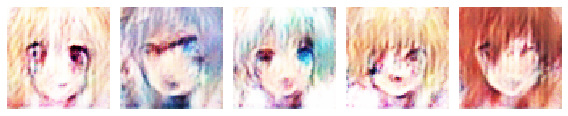

##################################################
epoch 4500


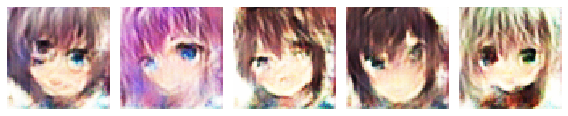

##################################################
epoch 5000


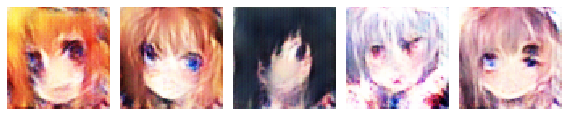

##################################################
epoch 5500


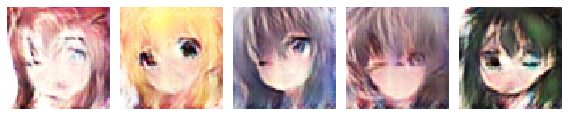

##################################################
epoch 6000


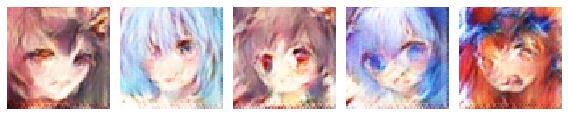

##################################################
epoch 6500


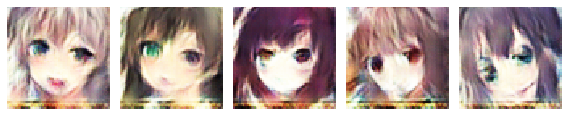

##################################################
epoch 7000


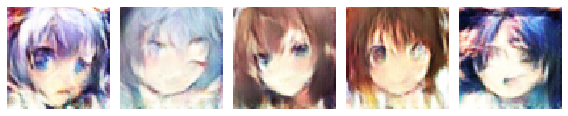

##################################################
epoch 7500


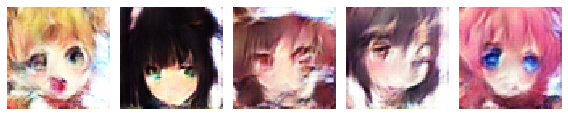

##################################################
epoch 8000


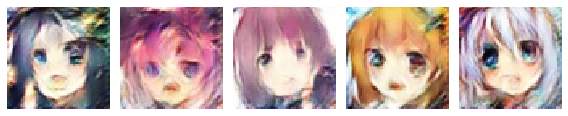

##################################################
epoch 8500


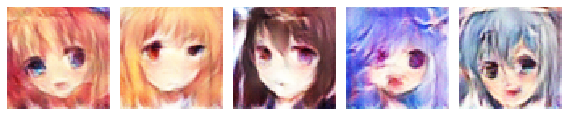

##################################################
epoch 9000


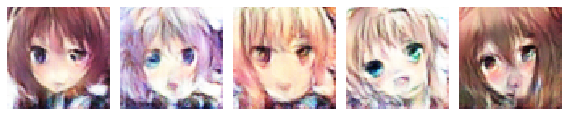

##################################################
epoch 9500


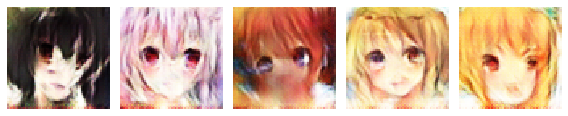

##################################################
epoch 10000


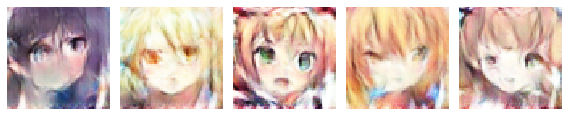

In [11]:
for epoch in range(0, 10000+1, 10000//20):
    print('#'*50)
    print('epoch' ,epoch)
    imgs = trainAndTest.sample_imgs(epoch=epoch)
    trans_imgs = imgs.transpose([0, 2, 3, 1])
    plot_one_row_imgs(trans_imgs)

In [12]:
10000*64/70000

9.142857142857142